# Harry Potter Character-Level Text Generation

This project builds a deep learning model that generates text character by character, trained on a text-only version of the Harry Potter books. The model learns to predict the next character in a sequence, allowing it to recreate the writing style, structure, and flow found in the original text. [web:4]

**Dataset**: Cleaned plain-text Harry Potter books (Kaggle) [web:4]  
**Tech Stack**: Python, TensorFlow/Keras, NumPy, Matplotlib


## Dataset Source

- Preprocessed text file: All 7 Harry Potter books  
- Removed: Formatting, chapter numbers, extra symbols  
- Link: [Harry Potter LSTM Dataset](https://www.kaggle.com/datasets/moxxis/harry-potter-lstm) 
- Size: ~5M+ characters


## Technologies Used

- **Python**  
- **TensorFlow / Keras** - Neural network modeling [web:6]  
- **NumPy** - Sequence processing  
- **Matplotlib** - Training metrics visualization


## Step 1: Load Dataset

Load text file and inspect first characters + total length


In [1]:
with open("/kaggle/input/harry-potter-lstm/Harry_Potter_all_books_preprocessed.txt", "r") as file:
  text= file.read()
print(text[:700])
print('Total characters:', len(text))


THE BOY WHO LIVED Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you very much .They were the last people youd expect to be involved in anything strange or mysterious because they just didnt hold with such nonsense .Mr Dursley was the director of a firm called Grunnings which made drills .He was a big beefy man with hardly any neck although he did have a very large mustache .Mrs Dursley was thin and blonde and had nearly twice the usual amount of neck which came in very useful as she spent so much of her time craning over garden fences spying on the neighbors .The Dursley s had a small son called Dudley and in their opinion there was no
Total characters: 5991293


## Step 2: Preprocessing Data

1. Extract unique characters → vocabulary  
2. Create char↔index mappings (stoi/itos)  
3. Convert text → integer tensor


In [2]:
chars= sorted(list(set(text)))
vocab= len(chars)
print('Unique chars:', chars)
print('Vocab size:', vocab)
print('-'*50)


Unique chars: [' ', '!', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '‘', '•', '■', '□']
Vocab size: 71
--------------------------------------------------


In [3]:
stoi= {ch:i for i, ch in enumerate(chars)}
itos= {i:ch for i, ch in enumerate(chars)}
print('stoi example:', {k:stoi[k] for k in chars[:10]})
print('itos example:', {0:itos[0], 1:itos[1], vocab-1:itos[vocab-1]})


stoi example: {' ': 0, '!': 1, '.': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9}
itos example: {0: ' ', 1: '!', 70: '□'}


In [4]:
import numpy as np
data= np.array([stoi[ch] for ch in text])
print('Data shape:', data.shape)
print('First 20:', data[:20])


Data shape: (5991293,)
First 20: [33 21 18  0 15 28 38  0 36 21 28  0 25 22 35 18 17  0 26 57]


## Step 3: Train/Validation Split

- **90/10 split**  
- Sequence length: 200 chars  
- Batch size: 128


In [5]:
SQ_LEN = 200
STEP = 3

split_idx = int(0.9 * len(data))
train_data = data[:split_idx]
val_data = data[split_idx:]

print('Full:', len(data))
print('Train:', len(train_data))
print('Val:', len(val_data))
print('Total:', len(train_data)+len(val_data))


Full: 5991293
Train: 5392163
Val: 599130
Total: 5991293


## Step 4: TF Data Pipeline

Creates batched datasets:  
`(input_seq[:-1], target_seq[1:])`

In [6]:
import tensorflow as tf

BATCH_SIZE = 128
BUFFER_SIZE = 10000

def create_dataset(data):
  ds= tf.data.Dataset.from_tensor_slices(data)
  ds=ds.batch(SQ_LEN+1, drop_remainder=True)
  ds=ds.map(lambda seq: (seq[:-1], seq[1:] ))
  ds=ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
  return ds

train_dataset= create_dataset(train_data)
val_dataset= create_dataset(val_data)

for i,j in train_dataset.take(1):
  print('Input shape:', i.shape, 'Target shape:', j.shape)


2026-01-30 12:20:14.601176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769775614.819074      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769775614.890498      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769775615.450113      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769775615.450157      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769775615.450160      55 computation_placer.cc:177] computation placer alr

Input shape: (128, 200) Target shape: (128, 200)


## Step 5: Build Model

**Architecture**: Embedding → Stateful LSTM → Dense 
- Vocab → 256-dim embeddings  
- LSTM(256, return_sequences=True, stateful=True)  
- ~1M parameters


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(vocab, 256),
    LSTM(256, return_sequences=True, stateful=True,
         recurrent_initializer='glorot_uniform'),
    Dense(vocab)
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Step 6: Compile & Train

- **Loss**: SparseCategoricalCrossentropy (from_logits=True) 
- **50 epochs**, state reset between epochs  
- Manual metric tracking


In [8]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

loss_fn = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=Adam(), loss=loss_fn, metrics=['accuracy'])

EPOCHS = 50
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    h = model.fit(train_dataset, validation_data=val_dataset, epochs=1, shuffle=False, verbose=1)
    
    history["loss"].append(h.history["loss"][0])
    history["val_loss"].append(h.history["val_loss"][0])
    if "accuracy" in h.history:
        history["accuracy"].append(h.history["accuracy"][0])
    if "val_accuracy" in h.history:
        history["val_accuracy"].append(h.history["val_accuracy"][0])
    
    model.layers[1].reset_states()



Epoch 1/50


I0000 00:00:1769775637.880497     123 cuda_dnn.cc:529] Loaded cuDNN version 91002


209/209 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.2821 - loss: 2.6825 - val_accuracy: 0.4493 - val_loss: 1.8873

Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4667 - loss: 1.8290 - val_accuracy: 0.5094 - val_loss: 1.6666

Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5213 - loss: 1.6286 - val_accuracy: 0.5404 - val_loss: 1.5552

Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5506 - loss: 1.5231 - val_accuracy: 0.5601 - val_loss: 1.4874

Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5708 - loss: 1.4533 - val_accuracy: 0.5729 - val_loss: 1.4391

Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5840 - loss: 1.4051 - val_accuracy: 0.5832 - val_loss: 1.4059

Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5932 - loss: 1.3698 - val_accuracy: 0.5901 - val_loss: 1.3786

Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6005 - loss: 1.3429 - val_

## Step 7: Training Curves
* 

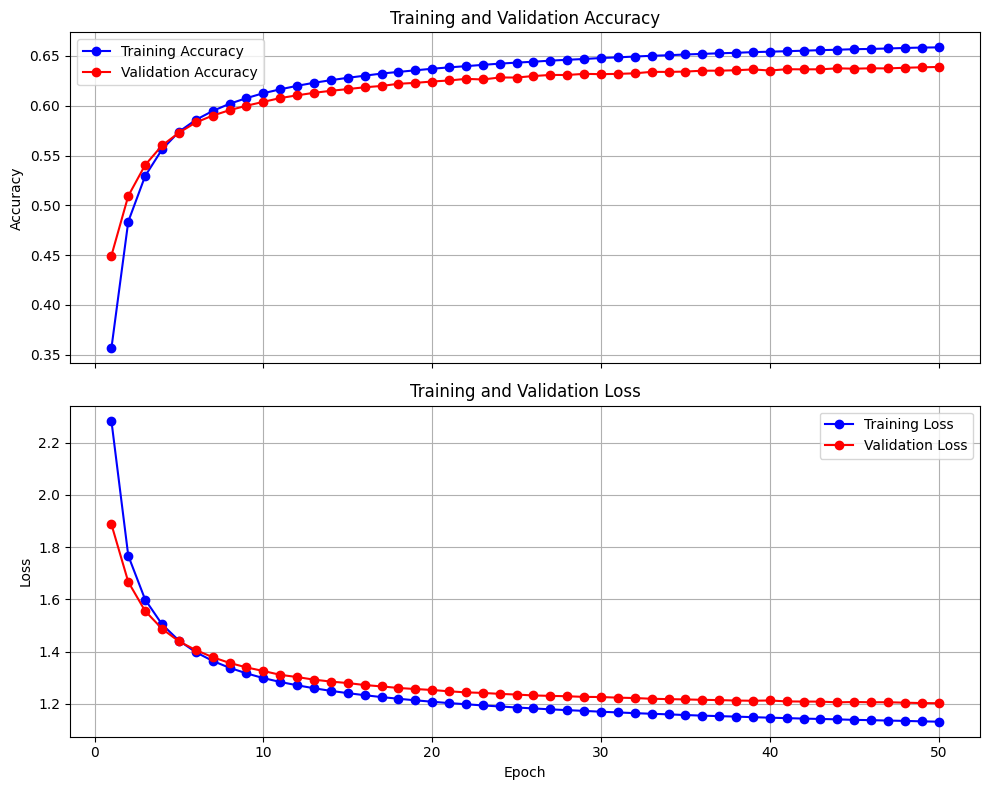

In [9]:
import matplotlib.pyplot as plt

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs_ran = len(loss)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(range(1, epochs_ran + 1), acc, 'bo-', label='Training Accuracy')
ax1.plot(range(1, epochs_ran + 1), val_acc, 'ro-', label='Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(range(1, epochs_ran + 1), loss, 'bo-', label='Training Loss')
ax2.plot(range(1, epochs_ran + 1), val_loss, 'ro-', label='Validation Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Training and Validation Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


## Step 8: Single-Step Generation

**Predict one char → append → repeat**  
`temperature`: Controls creativity (0.8 recommended) 

In [11]:
def generate_text(model, start_string, gen_length=400, temperature=1.0):
    input_eval = [stoi[c] for c in start_string if c in stoi]
    if not input_eval:
        input_eval = [stoi[' ']]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    model.layers[1].reset_states()
    
    for _ in range(gen_length):
        predictions = model(input_eval)
        predictions = tf.reshape(predictions, (1, -1, vocab))
        predictions = tf.squeeze(predictions, 0) / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        text_generated.append(itos[predicted_id])
        input_eval = tf.expand_dims([predicted_id], 0)
    return start_string + ''.join(text_generated)

print(generate_text(model, 
                   start_string="the great hall was silent, except for the faint rustling of cloaks and distant whispers.", 
                   gen_length=500, temperature=0.8))


the great hall was silent, except for the faint rustling of cloaks and distant whispers.I knew a student .Couldve done the other surrouff before the teachers the Hogwarts student however that Ron .The next room with it was brades every way behind him .Where are you told you out of the best oblitary ?Harry a few steam .But as he returned to the cold dress as though he was sure hes sure for what a standater hiticked shadow of the same too we couldnt have to be being led him since from the reachers .I dont think .Just seem to one inside him unfortunately not Hermione to be fussy as sh


## Step 9: Chunked Generation (Better Coherence)

**Generate chunks of 30 chars** while maintaining 100-char context window


In [12]:
def generate_text_chunks(model, start_string, total_length=400, chunk_size=30, temperature=1.0):
    input_eval = tf.expand_dims([stoi[c] for c in start_string], 0)
    generated = start_string
    model.layers[1].reset_states()
    
    while len(generated) < total_length:
        chunk_chars = []
        for _ in range(chunk_size):
            predictions = model(input_eval)
            predictions = tf.reshape(predictions, (1, -1, vocab))
            predictions = tf.squeeze(predictions, 0) / temperature
            predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
            chunk_chars.append(itos[predicted_id])
            input_eval = tf.expand_dims([predicted_id], 0)
        generated += ''.join(chunk_chars)
        input_eval = tf.expand_dims([stoi[c] for c in generated[-100:]], 0)
    return generated[:total_length]

print(generate_text_chunks(model,
                          start_string="the great hall was silent except for the faint rustling of cloaks and distant whispers.",
                          total_length=300, chunk_size=30, temperature=0.8))


the great hall was silent except for the faint rustling of cloaks and distant whispers.I didnt use the stone family leagued !Weve got to interest him .He gave up down her bed .He had never had any other said Hermione .Well now it Harry was only preveniency .Oh yes said Madam Rosmerta bowl obviously 


## Step 10: Save Trained Model

Save complete model (architecture + weights + optimizer) for later use


In [13]:
# Save complete model - easiest method for Keras
model.save('harry_potter_lstm_model.keras')

# Also save just weights (smaller file)
model.save_weights('harry_potter_lstm_weights.weights.h5')

print("✅ Model saved!")
print("- Complete model: 'harry_potter_lstm_model.keras'")
print("- Weights only: 'harry_potter_lstm_weights.weights.h5'")


✅ Model saved!
- Complete model: 'harry_potter_lstm_model.keras'
- Weights only: 'harry_potter_lstm_weights.weights.h5'


## Step 11: Load & Test Saved Model

Load model from disk and generate text to verify it works!


In [16]:
import tensorflow as tf

# Load COMPLETE model
loaded_model = tf.keras.models.load_model('harry_potter_lstm_model.keras')

print("✅ Model loaded successfully!")
print("Model summary:")
loaded_model.summary()

# FIX: Use the ORIGINAL generate_text function (not model method!)
print("\n" + "="*60)
print("Testing loaded model...")

test_text = generate_text(loaded_model,  # Pass MODEL as first arg
                         start_string="To night was the full moon and Harry felt",
                         gen_length=200,
                         temperature=0.8)
print(test_text)


✅ Model loaded successfully!
Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (128, 200, 256)        │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (128, 200, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (128, 200, 71)         │        18,247 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,685,207 (6.43 MB)

 Trainable params: 561,735 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,123,472 (4.29 MB)


Testing loaded model...
To night was the full moon and Harry felt up the bobbing one side of the witch past fins him a weak the air had been a great holding back to the fire disappointed and held with his hands and screamed Chocoan later his voice into the ground u
